In [1]:
## Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
from matplotlib.pyplot import figure

import sklearn

import os
import math

%matplotlib inline


## Import tensorflow and check the version
import tensorflow as tf
from tensorflow.keras.utils import plot_model

print("Running TensorFlow version ",tf.__version__)

# Parse tensorflow version
import re

version_match = re.match("([0-9]+)\.([0-9]+)", tf.__version__)
tf_major, tf_minor = int(version_match.group(1)) , int(version_match.group(2))
print("Version {v:d}, minor {m:d}".format(v=tf_major, m=tf_minor) )

Running TensorFlow version  2.8.0
Version 2, minor 8


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Flatten, GRU, SimpleRNN
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Conv2D, Conv1D, MaxPooling2D,MaxPooling1D

In [3]:
#Reading the daily AAPL stock data from git hub
df = pd.read_csv('https://raw.githubusercontent.com/Tejashri42/Stock_Pred_ML/main/Data/AAPL.csv',index_col=0)

data = df[['Adj Close']]

<AxesSubplot:xlabel='Dt'>

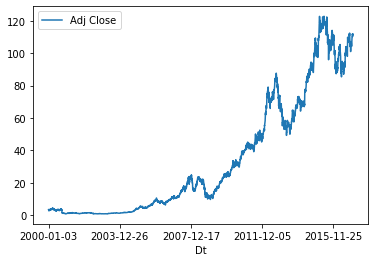

In [4]:
data.plot()

In [5]:
log_ret = df[['Adj Close']]
log_ret['Log_ret'] = np.log(df['Adj Close'])-np.log(df['Adj Close'].shift(-1))
log_ret = log_ret.drop(columns={"Adj Close"})
log_ret = log_ret.dropna()

<ipython-input-5-3d10fe935890>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log_ret['Log_ret'] = np.log(df['Adj Close'])-np.log(df['Adj Close'].shift(-1))


<AxesSubplot:xlabel='Dt'>

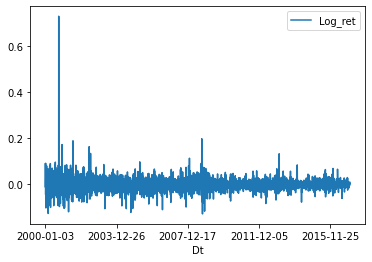

In [6]:
#Log Returns
log_ret.plot()

# LSTM Model with dropout layers 

I am first starting with an LSTM model to better understand the task at hand, the data and the model. In this model, I am only considering the AAPL adj close to keep things simple. In the later iterations, I will perform feature engineering and add additional features to our dataset. For this model, I have referenced the following Kaggle [link](https://www.kaggle.com/code/bryanb/stock-prices-forecasting-with-lstm/notebook)


In [7]:
#LSTM Model with parameters: data, split, scale, pred_window
#data - Training Dataset (dataframe)
#Split - Ratio to split the training dataset into insample and outsample (value between 0-1)
#scale - True or False, allows MinMaxScaler to scale data between the 0-1 range (Bool)
#pred_window - number of previous consecutive trading days to consider for predicting the price/return

def LSTM_Model(data, split, scale, pred_window):
  row_split = round(split*len(data))
  train, test = data.iloc[:row_split,:],data.iloc[row_split:,:]
  
  scaler_model = MinMaxScaler(feature_range=(0,1))
  scaler_model.fit(train.iloc[:,0].values.reshape(-1,1))
  if(scale):
    # Normalize data if scale = True
    train = scaler_model.transform(train.iloc[:,0].values.reshape(-1,1))
  else:
    train = train.iloc[:,0].values.reshape(-1,1)

  x_train = []
  y_train = []
  for x in range(pred_window, len(train)):
    x_train.append(train[x - pred_window:x, 0])
    y_train.append(train[x, 0])
    
  x_train, y_train = np.array(x_train), np.array(y_train)
  x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
  model = Sequential()
    
  model.add(LSTM(units = 60, return_sequences = True,input_shape = (x_train.shape[1],1)))
  model.add(Dropout(0.2))

  model.add(LSTM(units = 60, return_sequences = True))
  model.add(Dropout(0.2))

  model.add(LSTM(units = 60))
  model.add(Dropout(0.2))
    
  model.add(Dense(units=1))
    
  print(model.summary())  
  model.compile(optimizer='adam', 
              loss='mean_squared_error')
    
  #checkpointer = ModelCheckpoint(filepath = 'weights_best.hdf5', verbose = 2,  )

  history = model.fit(x_train, 
          y_train, 
          epochs=25, 
          batch_size = 32,
          #callbacks = [checkpointer]
          )
  

  return history, model,scaler_model,test


## LSTM for Prices

In [8]:
#Running the model for AAPL prices
pred_window = 45
split = 0.85
scale = True
hist_data, model,scaler, test = LSTM_Model(data,split,scale,pred_window)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 45, 60)            14880     
                                                                 
 dropout (Dropout)           (None, 45, 60)            0         
                                                                 
 lstm_1 (LSTM)               (None, 45, 60)            29040     
                                                                 
 dropout_1 (Dropout)         (None, 45, 60)            0         
                                                                 
 lstm_2 (LSTM)               (None, 60)                29040     
                                                                 
 dropout_2 (Dropout)         (None, 60)                0         
                                                                 
 dense (Dense)               (None, 1)                 6

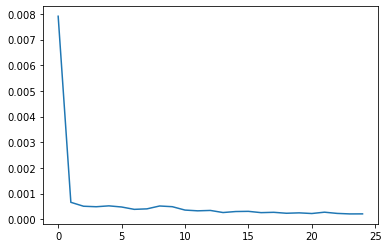

In [9]:
plt.plot(hist_data.history['loss'])

In [10]:
#Routine to return predicted prices
#Arguments: model, scaler model, scale (bool),test(test data)
def predictions(model,scaler,scale,test):
  model_inputs = data[len(data) - len(test) - pred_window:].values
  model_inputs = model_inputs.reshape(-1,1)
  if(scale):
    model_inputs = scaler.transform(model_inputs)
  x_test = []
  for x in range(pred_window, len(model_inputs)):
    x_test.append(model_inputs[x-pred_window:x, 0])

  x_test = np.array(x_test)
  x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1] ,1))

  predicted_prices = model.predict(x_test)
  predicted_prices = scaler.inverse_transform(predicted_prices)
  return predicted_prices

<ipython-input-11-66d168d3b009>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predicted prices'] = new[0].values


<AxesSubplot:xlabel='Dt'>

<Figure size 432x288 with 0 Axes>

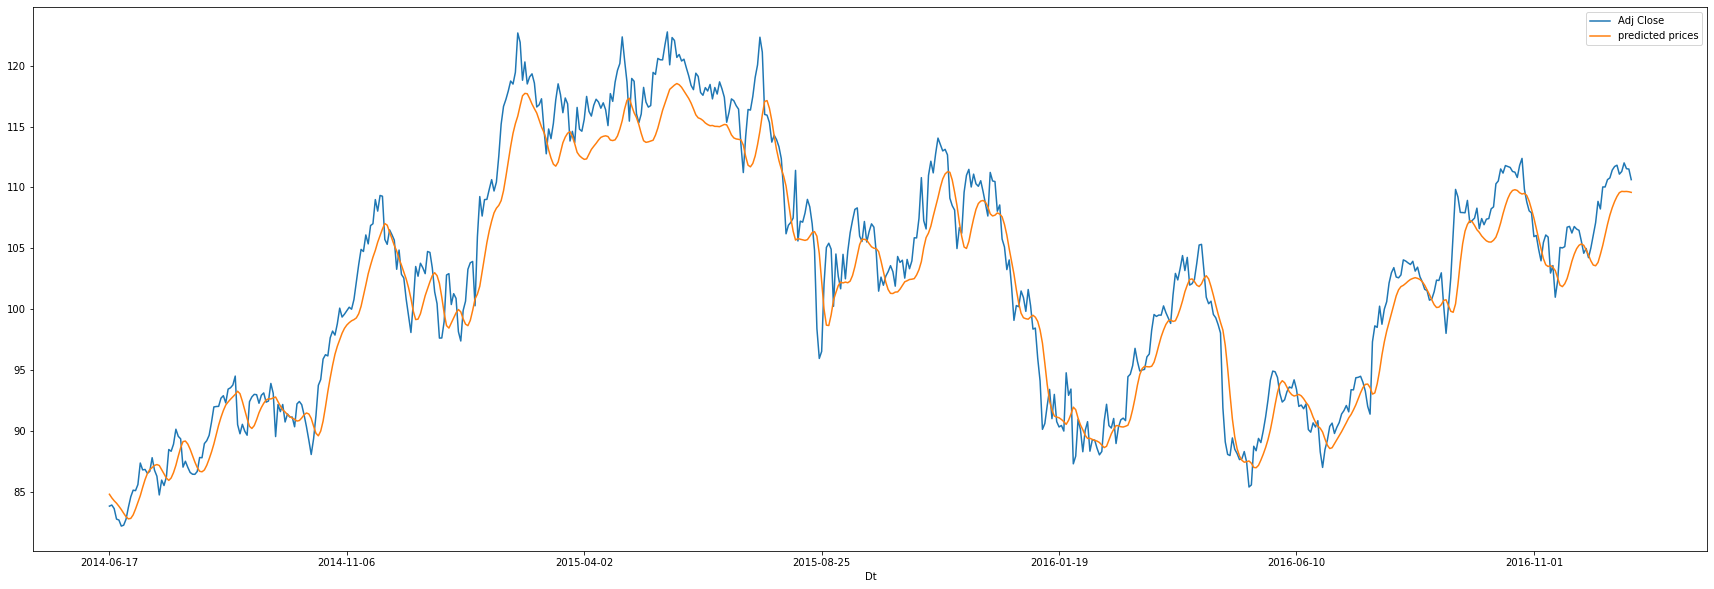

In [11]:

#Predicting and plotting Prices
predicted_prices = predictions(model,scaler,scale ,test)
new = pd.DataFrame(predicted_prices)
test['predicted prices'] = new[0].values

plt.figure()
test.plot(figsize=(30,10))


In [12]:
test['log_ret_pred']=np.log(test['predicted prices'])-np.log(test['predicted prices'].shift(-1))

<ipython-input-12-53e29c20a94c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['log_ret_pred']=np.log(test['predicted prices'])-np.log(test['predicted prices'].shift(-1))


In [13]:
test_returns = test.drop(columns = {'Adj Close','predicted prices'})
test_returns['actual returns']=log_ret['Log_ret']

<AxesSubplot:xlabel='Dt'>

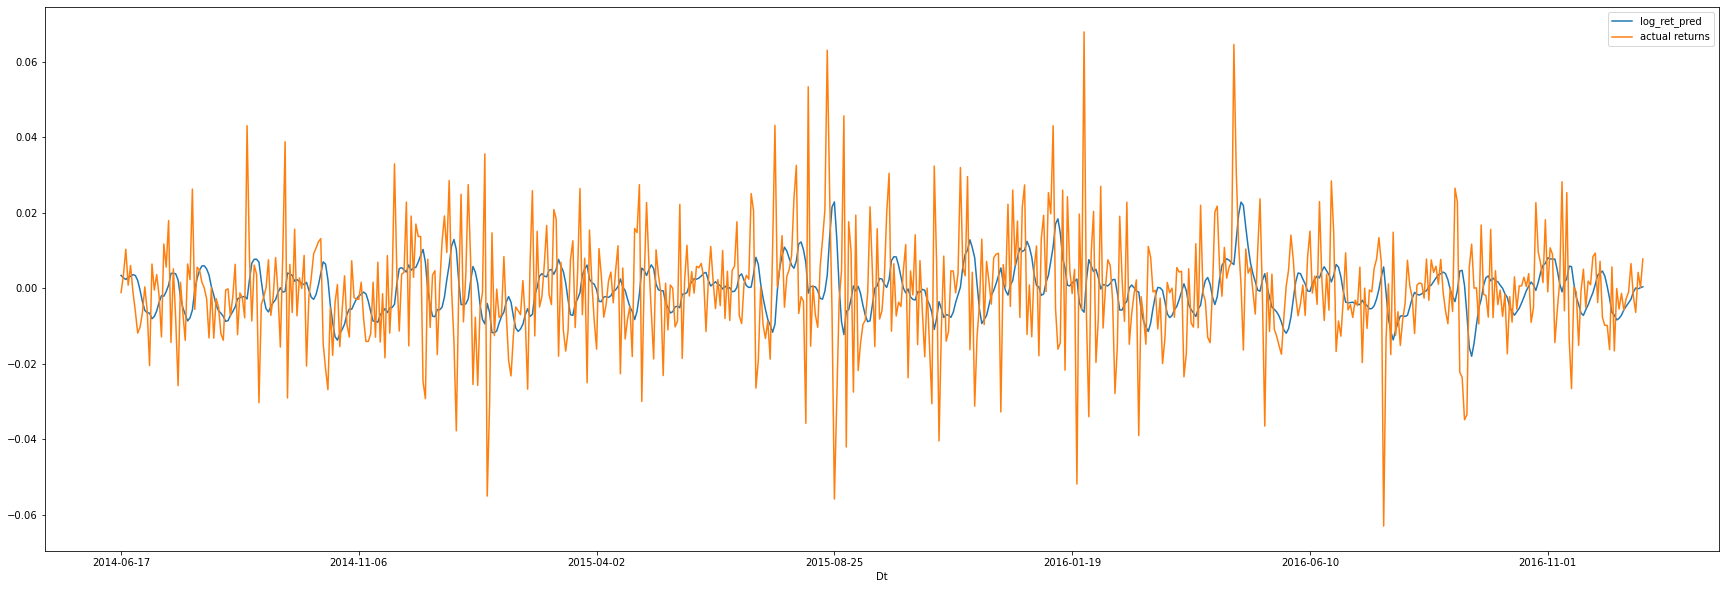

In [14]:
test_returns.plot(figsize=(30,10))

## LSTM for Returns - Log Returns

In [15]:

#Training the model on Log Returns
pred_window = 30
split = 0.85
scale = True
hist_ret ,model_ret,scaler_ret, test_ret = LSTM_Model(log_ret,split,scale,pred_window)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 30, 60)            14880     
                                                                 
 dropout_3 (Dropout)         (None, 30, 60)            0         
                                                                 
 lstm_4 (LSTM)               (None, 30, 60)            29040     
                                                                 
 dropout_4 (Dropout)         (None, 30, 60)            0         
                                                                 
 lstm_5 (LSTM)               (None, 60)                29040     
                                                                 
 dropout_5 (Dropout)         (None, 60)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                

<ipython-input-16-852f8dd1ead1>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_ret['predicted ret'] = new[0].values


<AxesSubplot:xlabel='Dt'>

<Figure size 432x288 with 0 Axes>

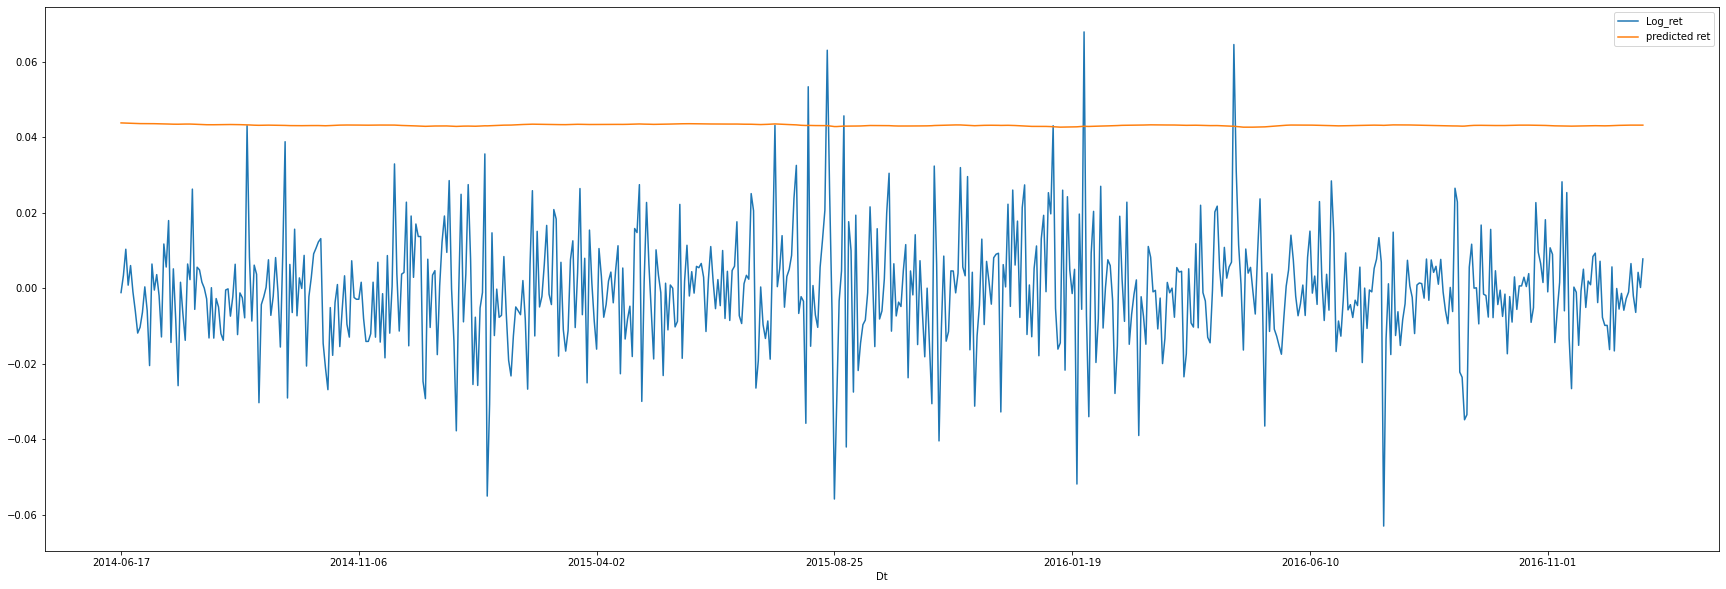

In [16]:

#predicting and plotting log returns

predicted_ret = predictions(model_ret,scaler_ret,scale ,test_ret)
new = pd.DataFrame(predicted_ret)
test_ret['predicted ret'] = new[0].values
plt.figure()
test_ret.plot(figsize=(30,10))


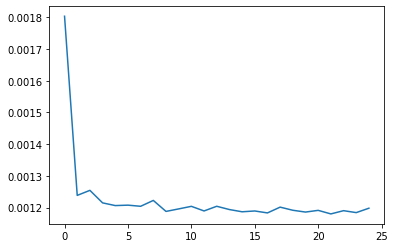

In [17]:
plt.plot(hist_ret.history['loss'])

**LSTM seems to work for Price predictions but not for log returns predictions?**

As we can see from the above two graphs the LSTM fails for the log-returns and almost predicts a uniform return. However the price predictions work better, probably a little too much better which can point towards overfitting

I searched a couple of articles over the internet to understand this behaviour

https://stats.stackexchange.com/questions/497877/forecasting-prices-vs-returns-by-deep-learning 

This stats.stackexchange post had the same issue as I do, they tried to use LSTM to forecast prices and then used the same model for returns but the returns model fails as mine does. One of the explanations are towards stationarity and how even when the stock prices in itself are non-stationarity, their returns especially log returns move towards stationarity. 

As per their explanation, the LSTM model works well with non-stationary data (prices) as they can use this to their advantage for prediction. While the log-returns are stationary and hence the LSTM model cannot use this for predictions.

https://towardsdatascience.com/machine-learning-in-finance-why-you-should-not-use-lstms-to-predict-the-stock-market-3f7239b9832c 

The above article talks about how LSTM is just predicting prices close to the previous close and hence lack the predictive quality needed by the model, if solely done on the basis of the last close




## Time Series: Stationary or Non-Stationary?

### Augmented Dickey-Fuller (ADF) Test for stationarity
The ADF is a unit root test to check if a series is stationary or not. The Null Hypothesis is that the series has a unit root and presence of a unit root implies non-stationarity 

In [18]:
from statsmodels.tsa.stattools import adfuller
data_result = adfuller(data['Adj Close'])
print('ADF Statistic: %f'%data_result[0])
print('p-value: %f'%data_result[1])
for key,value in data_result[4].items():
  print('\t%s:%.3f'%(key,value))

ADF Statistic: 0.414737
p-value: 0.982038
	1%:-3.432
	5%:-2.862
	10%:-2.567


In [19]:
log_result = adfuller(log_ret['Log_ret'])
print('ADF Statistic: %f'%log_result[0])
print('p-value: %f'%log_result[1])
for key,value in log_result[4].items():
  print('\t%s:%.3f'%(key,value))

ADF Statistic: -13.948614
p-value: 0.000000
	1%:-3.432
	5%:-2.862
	10%:-2.567


For the ADF test, the more negative the ADF stat, the more likely we are to reject the null hypothesis. Rejecting the null hypothesis means that there is no unit root and hence the series is stationary. In case of the log returns as our ADF stat is -13.9 and the p-value is significant, this implies that the log-returns are stationary. This is inline with the above explanation "*many financial time series do not exhibit stationarity, but often the changes in them, perhaps after applying a log transformation, are approximately stationary.*"

Conclusion: I plan to perform the predictions on stock prices and then convert them to returns rather than predicting returns

# Feature Engineering

Now that I ran a preliminary LSTM model using only AAPL adj close, I plan to add more features and perform feature engineering on them to achieve better predictions.

In [20]:
!pip install pandas-ta

You should consider upgrading via the '/Users/tejashriprabhu/miniforge3/envs/env_tf/bin/python -m pip install --upgrade pip' command.


In [21]:
import pandas_ta as ta

### Adding Tech stocks and the Index as parameters

In [22]:
# Adding tech stocks and SPY index
tech_list = ["AAPL", "GOOG", "MSFT","ADBE","SPY"]
df_list = []
for i, stock in zip(range(len(tech_list)),tech_list):
    globals()[stock] = pd.read_csv('https://raw.githubusercontent.com/Tejashri42/Stock_Pred_ML/main/Data/'+tech_list[i]+'.csv',index_col=0)
    globals()[stock].index = pd.to_datetime(globals()[stock].index)
    df_list.append(globals()[stock])

In [23]:
for d in df_list:
  print(d.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4277 entries, 2000-01-03 to 2016-12-30
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  4277 non-null   float64
 1   Close      4277 non-null   float64
 2   Div        4277 non-null   float64
 3   Factor     4277 non-null   float64
 4   High       4277 non-null   float64
 5   Low        4277 non-null   float64
 6   Open       4277 non-null   float64
 7   Volume     4277 non-null   float64
dtypes: float64(8)
memory usage: 300.7 KB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4277 entries, 2000-01-03 to 2016-12-30
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  3115 non-null   float64
 1   Close      3115 non-null   float64
 2   Div        3115 non-null   float64
 3   Factor     3115 non-null   float64
 4   High       3115 non-null   float64
 5   Low        3115 non-

We see GOOG has null values, this is attributed to their late IPO (2004), and we have data from 2000. We can impute the data points, but since we have other features and imputing the stock price before their IPO will not make sense in the financial sense either, and so I plan to drop GOOG for now.  

In [24]:
tech_list = ["AAPL","MSFT","ADBE","SPY"]
tech_list_close = ['AAPL_close','MSFT_close','ADBE_close','SPY_close']
tech_list_high = ['AAPL_high','MSFT_high','ADBE_high','SPY_high']
tech_list_low = ['AAPL_low','MSFT_low','ADBE_low','SPY_low']
main_frame = pd.DataFrame()

In [25]:
for stock, stock_close,stock_high,stock_low in zip(tech_list,tech_list_close,tech_list_high,tech_list_low):
    main_frame[stock_close]= globals()[stock]['Adj Close']
    main_frame[stock_high]= globals()[stock]['High']
    main_frame[stock_low]= globals()[stock]['Low']

In [26]:
main_frame.head()

,AAPL_close,AAPL_high,AAPL_low,MSFT_close,MSFT_high,MSFT_low,ADBE_close,ADBE_high,ADBE_low,SPY_close,SPY_high,SPY_low
Dt,,,,,,,,,,,,
2000-01-03,3.4785,112.500,101.688,37.6233,118.625,112.000,16.2747,67.500,64.250,100.4705,148.2472,143.875
2000-01-04,3.1852,110.625,101.188,36.3524,117.125,112.250,14.9094,65.813,59.938,96.5415,144.0630,139.641
2000-01-05,3.2318,110.563,103.000,36.7357,116.375,109.375,15.2042,62.750,58.250,96.7142,141.5284,137.250
2000-01-06,2.9521,107.000,95.000,35.5051,113.875,108.375,15.3283,62.625,60.625,95.1599,141.5000,137.750
2000-01-07,3.0920,101.000,95.500,35.9691,112.250,107.313,16.0730,64.750,60.875,100.6864,145.7500,140.063


In [27]:
main_frame.tail()

,AAPL_close,AAPL_high,AAPL_low,MSFT_close,MSFT_high,MSFT_low,ADBE_close,ADBE_high,ADBE_low,SPY_close,SPY_high,SPY_low
Dt,,,,,,,,,,,,
2016-12-23,111.3073,116.5255,115.59,60.1241,63.5400,62.80,105.02,105.420,104.61,214.2890,225.72,225.21
2016-12-27,112.0142,117.8000,116.49,60.1621,64.0700,63.21,104.98,105.900,104.86,214.8206,226.73,226.00
2016-12-28,111.5366,118.0170,116.20,59.8864,63.4009,62.83,103.77,105.160,103.50,213.0452,226.59,224.27
2016-12-29,111.5079,117.1094,116.40,59.8008,63.2000,62.73,103.68,104.391,103.41,212.9978,224.89,223.84
2016-12-30,110.6386,117.2000,115.43,59.0783,62.9900,62.03,102.95,104.220,102.47,212.2193,224.83,222.73


### Adding Technical Indicators

In [28]:
!pip install statsmodels

You should consider upgrading via the '/Users/tejashriprabhu/miniforge3/envs/env_tf/bin/python -m pip install --upgrade pip' command.


#### SMA - Simple Moving Average

In [29]:
#Adding SMA
tech_ind = '_SMA'
SMA_ls = [s + tech_ind for s in tech_list]

In [30]:
main_frame_TA = main_frame.copy()
for ls, stock_close in zip(SMA_ls,tech_list_close):
  main_frame_TA[ls] = ta.sma(main_frame[stock_close])

In [31]:
main_frame_TA.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4277 entries, 2000-01-03 to 2016-12-30
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   AAPL_close  4277 non-null   float64
 1   AAPL_high   4277 non-null   float64
 2   AAPL_low    4277 non-null   float64
 3   MSFT_close  4277 non-null   float64
 4   MSFT_high   4277 non-null   float64
 5   MSFT_low    4277 non-null   float64
 6   ADBE_close  4277 non-null   float64
 7   ADBE_high   4277 non-null   float64
 8   ADBE_low    4277 non-null   float64
 9   SPY_close   4277 non-null   float64
 10  SPY_high    4277 non-null   float64
 11  SPY_low     4277 non-null   float64
 12  AAPL_SMA    4268 non-null   float64
 13  MSFT_SMA    4268 non-null   float64
 14  ADBE_SMA    4268 non-null   float64
 15  SPY_SMA     4268 non-null   float64
dtypes: float64(16)
memory usage: 568.0 KB


In [32]:
main_frame_TA.tail()

,AAPL_close,AAPL_high,AAPL_low,MSFT_close,MSFT_high,MSFT_low,ADBE_close,ADBE_high,ADBE_low,SPY_close,SPY_high,SPY_low,AAPL_SMA,MSFT_SMA,ADBE_SMA,SPY_SMA
Dt,,,,,,,,,,,,,,,,
2016-12-23,111.3073,116.5255,115.59,60.1241,63.5400,62.80,105.02,105.420,104.61,214.2890,225.72,225.21,110.70836,59.91491,105.208,214.11021
2016-12-27,112.0142,117.8000,116.49,60.1621,64.0700,63.21,104.98,105.900,104.86,214.8206,226.73,226.00,111.08664,60.02044,105.190,214.23797
2016-12-28,111.5366,118.0170,116.20,59.8864,63.4009,62.83,103.77,105.160,103.50,213.0452,226.59,224.27,111.23662,60.02139,104.952,214.04567
2016-12-29,111.5079,117.1094,116.40,59.8008,63.2000,62.73,103.68,104.391,103.41,212.9978,224.89,223.84,111.38373,60.04231,104.739,214.02607
2016-12-30,110.6386,117.2000,115.43,59.0783,62.9900,62.03,102.95,104.220,102.47,212.2193,224.83,222.73,111.38373,60.00048,104.524,213.84085


In [33]:
#SMA - Since SMA is calculated over 10 days the 1st 10 rows become NA

In [34]:
main_frame_TA.head()

,AAPL_close,AAPL_high,AAPL_low,MSFT_close,MSFT_high,MSFT_low,ADBE_close,ADBE_high,ADBE_low,SPY_close,SPY_high,SPY_low,AAPL_SMA,MSFT_SMA,ADBE_SMA,SPY_SMA
Dt,,,,,,,,,,,,,,,,
2000-01-03,3.4785,112.500,101.688,37.6233,118.625,112.000,16.2747,67.500,64.250,100.4705,148.2472,143.875,NaN,NaN,NaN,NaN
2000-01-04,3.1852,110.625,101.188,36.3524,117.125,112.250,14.9094,65.813,59.938,96.5415,144.0630,139.641,NaN,NaN,NaN,NaN
2000-01-05,3.2318,110.563,103.000,36.7357,116.375,109.375,15.2042,62.750,58.250,96.7142,141.5284,137.250,NaN,NaN,NaN,NaN
2000-01-06,2.9521,107.000,95.000,35.5051,113.875,108.375,15.3283,62.625,60.625,95.1599,141.5000,137.750,NaN,NaN,NaN,NaN
2000-01-07,3.0920,101.000,95.500,35.9691,112.250,107.313,16.0730,64.750,60.875,100.6864,145.7500,140.063,NaN,NaN,NaN,NaN


#### RSI - Relative Strength Index

In [35]:
#Adding RSI
tech_ind = '_RSI'
RSI_ls = [s + tech_ind for s in tech_list]
for ls, stock_close in zip(RSI_ls,tech_list_close):
  main_frame_TA[ls] = ta.rsi(main_frame[stock_close])

In [36]:
RSI_ls

['AAPL_RSI', 'MSFT_RSI', 'ADBE_RSI', 'SPY_RSI']

In [37]:
main_frame_TA.head()

,AAPL_close,AAPL_high,AAPL_low,MSFT_close,MSFT_high,MSFT_low,ADBE_close,ADBE_high,ADBE_low,SPY_close,SPY_high,SPY_low,AAPL_SMA,MSFT_SMA,ADBE_SMA,SPY_SMA,AAPL_RSI,MSFT_RSI,ADBE_RSI,SPY_RSI
Dt,,,,,,,,,,,,,,,,,,,,
2000-01-03,3.4785,112.500,101.688,37.6233,118.625,112.000,16.2747,67.500,64.250,100.4705,148.2472,143.875,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-04,3.1852,110.625,101.188,36.3524,117.125,112.250,14.9094,65.813,59.938,96.5415,144.0630,139.641,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-05,3.2318,110.563,103.000,36.7357,116.375,109.375,15.2042,62.750,58.250,96.7142,141.5284,137.250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-06,2.9521,107.000,95.000,35.5051,113.875,108.375,15.3283,62.625,60.625,95.1599,141.5000,137.750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-07,3.0920,101.000,95.500,35.9691,112.250,107.313,16.0730,64.750,60.875,100.6864,145.7500,140.063,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### ROC - Rate of Change

In [38]:
#Adding ROC
tech_ind = '_ROC'
ROC_ls = [s + tech_ind for s in tech_list]
for ls, stock_close in zip(ROC_ls,tech_list_close):
  main_frame_TA[ls] = ta.momentum.roc(main_frame[stock_close])

#### CCI - Commodity Chanel Index

In [39]:
#Adding CCI
tech_ind = '_CCI'
CCI_ls = [s + tech_ind for s in tech_list]
for ls, stock_close, stock_low, stock_high in zip(CCI_ls,tech_list_close,tech_list_low,tech_list_high):
  main_frame_TA[ls] = ta.momentum.cci(close = main_frame[stock_close],low = main_frame_TA[stock_low],high = main_frame_TA[stock_high])

In [40]:
main_frame_TA.tail()

,AAPL_close,AAPL_high,AAPL_low,MSFT_close,MSFT_high,MSFT_low,ADBE_close,ADBE_high,ADBE_low,SPY_close,...,ADBE_RSI,SPY_RSI,AAPL_ROC,MSFT_ROC,ADBE_ROC,SPY_ROC,AAPL_CCI,MSFT_CCI,ADBE_CCI,SPY_CCI
Dt,,,,,,,,,,,,,,,,,,,,,
2016-12-23,111.3073,116.5255,115.59,60.1241,63.5400,62.80,105.02,105.420,104.61,214.2890,...,51.395508,66.451029,2.255350,2.049507,0.680663,0.234157,53.429452,58.310734,31.383992,16.658946
2016-12-27,112.0142,117.8000,116.49,60.1621,64.0700,63.21,104.98,105.900,104.86,214.8206,...,51.222500,68.087151,3.495104,1.785412,-0.171168,0.598287,83.615183,79.274622,37.266172,67.184885
2016-12-28,111.5366,118.0170,116.20,59.8864,63.4009,62.83,103.77,105.160,103.50,213.0452,...,46.160516,57.926734,1.362999,0.015866,-2.242110,-0.894551,74.221851,29.586179,-84.591494,-93.338645
2016-12-29,111.5079,117.1094,116.40,59.8008,63.2000,62.73,103.68,104.391,103.41,212.9978,...,45.797982,57.679258,1.336916,0.351056,-2.013042,-0.091935,57.555996,-0.365066,-128.449152,-181.054670
2016-12-30,110.6386,117.2000,115.43,59.0783,62.9900,62.03,102.95,104.220,102.47,212.2193,...,42.857812,53.626955,0.000000,-0.703065,-2.045671,-0.865225,0.320881,-105.735730,-171.859958,-193.725530


### Data Visualization

In [41]:
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
main_frame_TA_t=main_frame_TA.transpose()

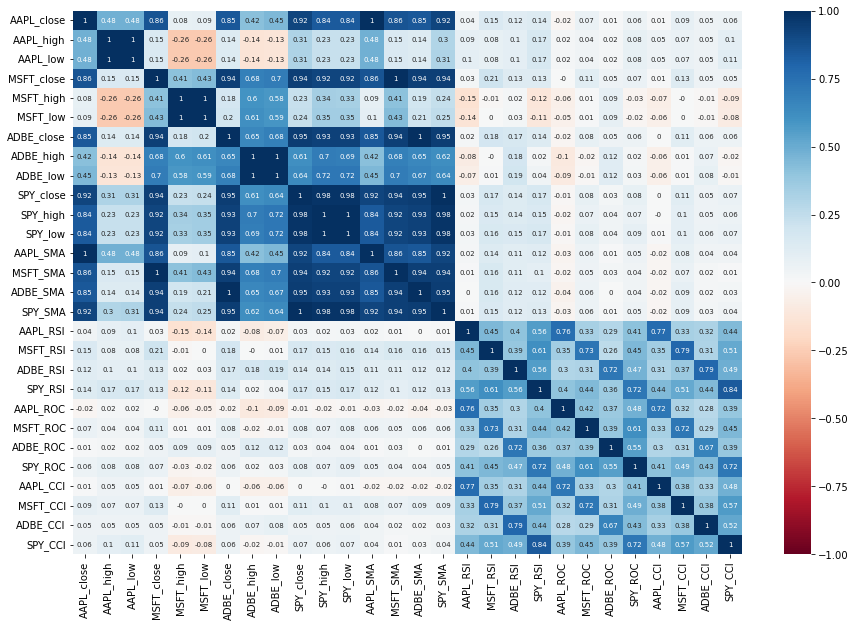

In [42]:
#Correlation Heatmap
plt.figure(figsize=(15,10))
correlations = main_frame_TA.corr()
sns.heatmap(round(correlations,2), cmap='RdBu', annot=True, 
            annot_kws={"size": 7}, vmin=-1, vmax=1);

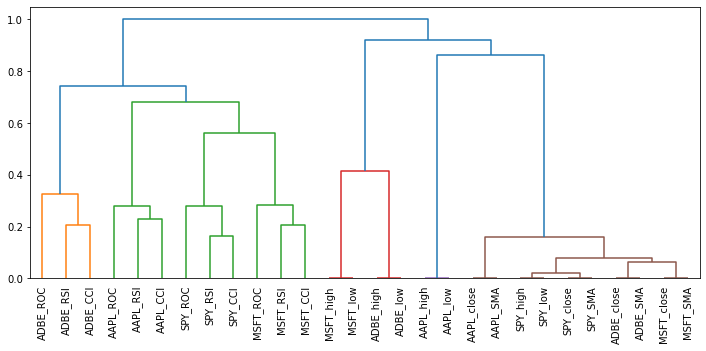

In [43]:
#Dendogram
plt.figure(figsize=(12,5))
dissimilarity = 1 - abs(correlations)
Z = linkage(squareform(dissimilarity), 'complete')

dendrogram(Z, labels=main_frame_TA.columns, orientation='top', 
           leaf_rotation=90);

Based on the above correlation and a couple of iterations of the CNN model below. I am removing SMA, high, and low as they are highly correlated to the price and did not seem to be adding value to the model

In [44]:
main_frame_TA = main_frame_TA.drop(columns =SMA_ls)
main_frame_TA = main_frame_TA.drop(columns =tech_list_high)
main_frame_TA = main_frame_TA.drop(columns =tech_list_low)

In [45]:
main_frame_TA.head()

,AAPL_close,MSFT_close,ADBE_close,SPY_close,AAPL_RSI,MSFT_RSI,ADBE_RSI,SPY_RSI,AAPL_ROC,MSFT_ROC,ADBE_ROC,SPY_ROC,AAPL_CCI,MSFT_CCI,ADBE_CCI,SPY_CCI
Dt,,,,,,,,,,,,,,,,
2000-01-03,3.4785,37.6233,16.2747,100.4705,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-04,3.1852,36.3524,14.9094,96.5415,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-05,3.2318,36.7357,15.2042,96.7142,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-06,2.9521,35.5051,15.3283,95.1599,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-07,3.0920,35.9691,16.0730,100.6864,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
main_frame_TA = main_frame_TA.dropna()

## Feature Engineering for CNN and Time series

**Changing the input shape to fit the CNN model**

As CNN needs the input shape to be 4D or of the dimension (batch_size, height, width, depth), we need to convert our 2D data to 3D (ignoring batch_size)

** Vectorization of multivariate time-series data**
Additionally since our data is timeseries, we need to get a time step or time window and modify the data as per the time step. I referenced the [link](https://machinelearningmastery.com/how-to-develop-convolutional-neural-network-models-for-time-series-forecasting/) for a better understanding on how to perform this transition



In [47]:
main_frame_TA.shape

(4263, 16)

## Data Preprocessing

Step 1:
Splitting the train-test data, keeping shuffle = False as this is a timeseries data and we need to maintain the time order

In [48]:
X=main_frame_TA
y=main_frame_TA.iloc[:,0]
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X,y,test_size =0.25,random_state = 42,shuffle=False)
y_act = y_test

In [49]:
print("X_train shape: ",X_train.shape)
print("y_train shape: ",y_train.shape)
print("X_test shape: ",X_test.shape)
print("y_test shape: ",y_test.shape)

X_train shape:  (3197, 16)
y_train shape:  (3197,)
X_test shape:  (1066, 16)
y_test shape:  (1066,)


Step 2: Scaling the data in the range of (0,1)

In [50]:
#Scaling the data using MinMaxScaler to avoid vanishing gradient issues

def scale_the_data(seq):
  scaler_model = MinMaxScaler(feature_range=(0,1))
  scaler_model.fit(seq)
  return scaler_model


In [51]:
X_train_smodel = scale_the_data(X_train)
y_train_smodel = scale_the_data(y_train.values.reshape(-1,1))

In [52]:
#Transforming the data to 0,1 range

X_train = X_train_smodel.transform(X_train)
y_train = y_train_smodel.transform(y_train.values.reshape(-1,1))
X_test  = X_train_smodel.transform(X_test)
y_test = y_train_smodel.transform(y_test.values.reshape(-1,1))

In [53]:
print("X_train shape: ",X_train.shape)
print("y_train shape: ",y_train.shape)
print("X_test shape: ",X_test.shape)
print("y_test shape: ",y_test.shape)

X_train shape:  (3197, 16)
y_train shape:  (3197, 1)
X_test shape:  (1066, 16)
y_test shape:  (1066, 1)


Step 3: Preparing Timesteps and window

In [54]:
#This routine creates the time steps for the data
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end = i+ n_steps
		# check if we are beyond the dataset
		if end > len(sequences)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end, :], sequences[end:end+1, 0]
		X.append(seq_x)  
		y.append(seq_y)
	return np.array(X), np.array(y)

In [55]:
pred_window = 60
Xs_train, ys_train =split_sequences(np.array(X_train),pred_window)
Xs_test, ys_test =split_sequences(np.array(X_test),pred_window)


In [56]:
#The shape is now suitable for Conv1D
print("Xs_train shape: ",Xs_train.shape)
print("ys_train shape: ",ys_train.shape)
print("Xs_test shape: ",Xs_test.shape)
print("ys_test shape: ",ys_test.shape)

Xs_train shape:  (3137, 60, 16)
ys_train shape:  (3137, 1)
Xs_test shape:  (1006, 60, 16)
ys_test shape:  (1006, 1)


# CNN Model

## 1D CNN for prices

In [57]:
#Running a 1D CNN model
model_CNN1 = None

input_shape = Xs_train[2].shape

# YOUR CODE HERE
model_CNN1 = Sequential()
model_CNN1.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=input_shape))
model_CNN1.add(MaxPooling1D(pool_size=4))
model_CNN1.add(Flatten())
model_CNN1.add(Dense(80, activation='relu'))
model_CNN1.add(Dense(1))


model_CNN1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 59, 64)            2112      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 14, 64)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 896)               0         
                                                                 
 dense_2 (Dense)             (None, 80)                71760     
                                                                 
 dense_3 (Dense)             (None, 1)                 81        
                                                                 
Total params: 73,953
Trainable params: 73,953
Non-trainable params: 0
__________________________________________________

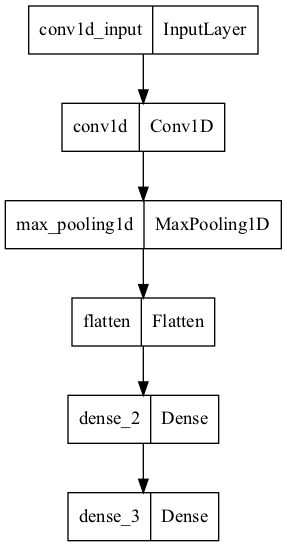

In [58]:
plot_model(model_CNN1)

In [59]:
model_CNN1.compile(optimizer='adam', loss='mse')

In [60]:
Xs_train = Xs_train.reshape(Xs_train.shape[0],Xs_train.shape[1],Xs_train.shape[2])

In [61]:
max_epochs = 30
history_CNN1 = model_CNN1.fit(Xs_train, ys_train, 
                          epochs=max_epochs,  
                          shuffle=False
                         )

Epoch 1/30
99/99 [==============================] - 1s 5ms/step - loss: 0.0144
Epoch 2/30
99/99 [==============================] - 0s 5ms/step - loss: 0.0346
Epoch 3/30
99/99 [==============================] - 0s 5ms/step - loss: 0.0264
Epoch 4/30
99/99 [==============================] - 0s 5ms/step - loss: 0.0452
Epoch 5/30
99/99 [==============================] - 0s 5ms/step - loss: 0.0267
Epoch 6/30
99/99 [==============================] - 0s 5ms/step - loss: 0.0255
Epoch 7/30
99/99 [==============================] - 0s 5ms/step - loss: 0.0097
Epoch 8/30
99/99 [==============================] - 0s 5ms/step - loss: 0.0260
Epoch 9/30
99/99 [==============================] - 0s 5ms/step - loss: 0.0239
Epoch 10/30
99/99 [==============================] - 0s 5ms/step - loss: 0.0379
Epoch 11/30
99/99 [==============================] - 0s 5ms/step - loss: 0.0438
Epoch 12/30
99/99 [==============================] - 0s 5ms/step - loss: 0.0242
Epoch 13/30
99/99 [==============================

In [62]:
ys_pred = model_CNN1.predict(Xs_test)

In [63]:
y_pred = y_train_smodel.inverse_transform(ys_pred)

In [64]:
y_cnn = pd.DataFrame()
y_cnn['y_test'] = y_act[pred_window:,]
y_cnn['y_pred']= y_pred

In [65]:
y_cnn.tail()

,y_test,y_pred
Dt,,
2016-12-23,111.3073,56.590454
2016-12-27,112.0142,57.685757
2016-12-28,111.5366,57.802597
2016-12-29,111.5079,58.341515
2016-12-30,110.6386,57.808235


<AxesSubplot:xlabel='Dt'>

<Figure size 432x288 with 0 Axes>

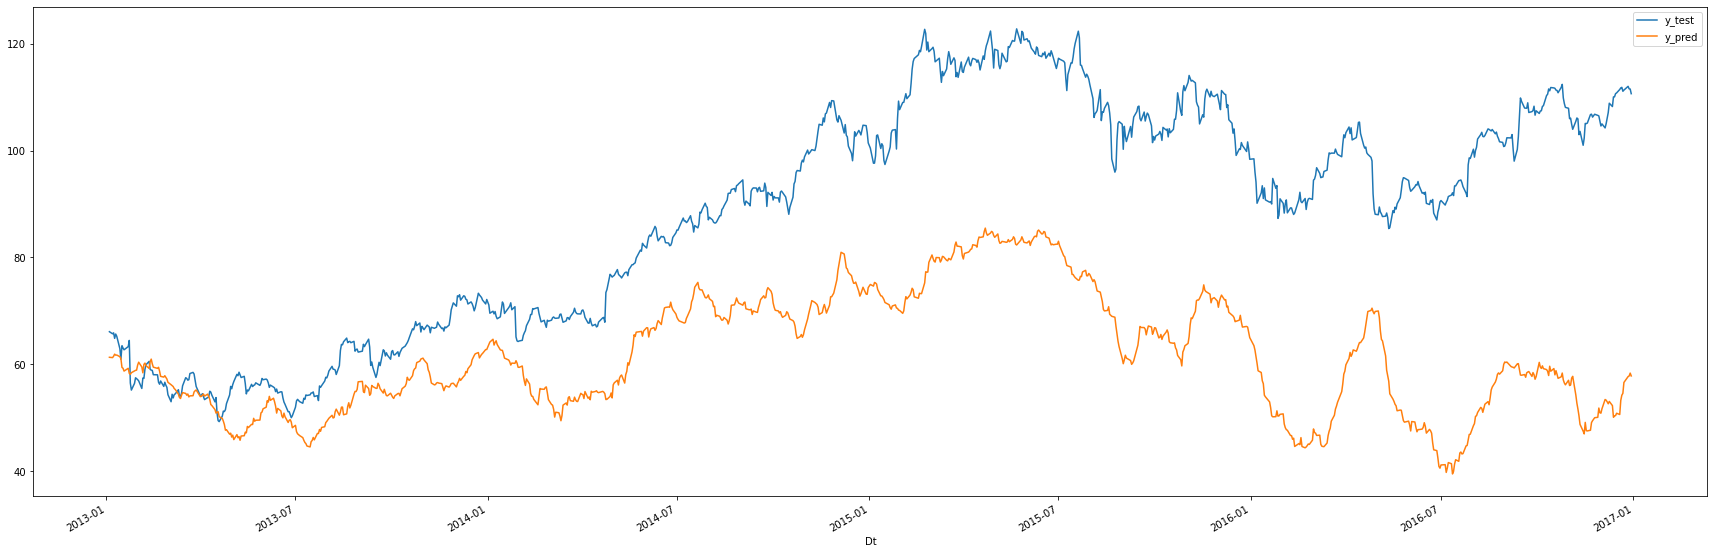

In [66]:
plt.figure()
y_cnn.plot(figsize=(30,10))

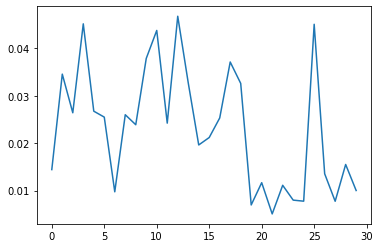

In [67]:
plt.plot(history_CNN1.history['loss'])

In [68]:
model_CNN1.evaluate(Xs_test,ys_test)

32/32 [==============================] - 0s 3ms/step - loss: 0.1333


0.13330601155757904

In [69]:
y_cnn_pct = y_cnn.pct_change()
y_cnn_pct = y_cnn_pct.dropna()

<AxesSubplot:xlabel='Dt'>

<Figure size 432x288 with 0 Axes>

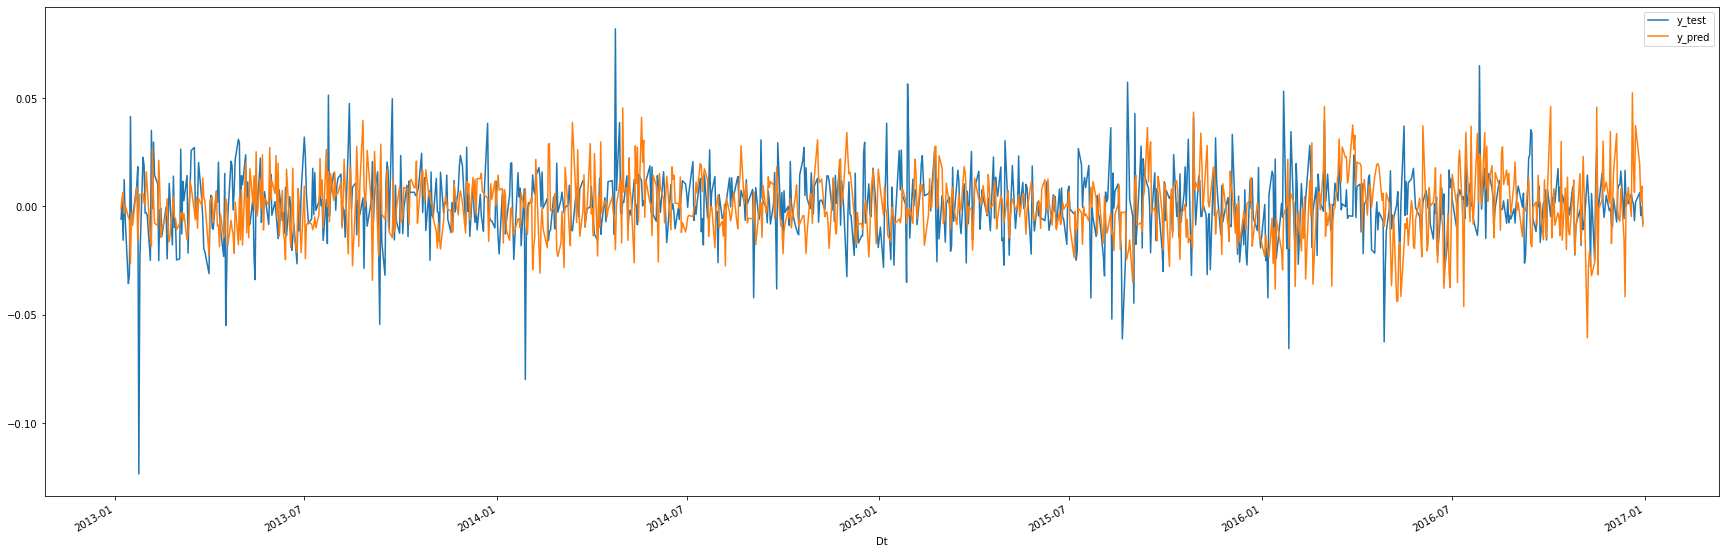

In [70]:
plt.figure()
y_cnn_pct.plot(figsize=(30,10))

In [71]:
model_name0 = "Model_CNN1D"
score_CNN = model_CNN1.evaluate(Xs_test, ys_test, verbose=0)
print("test loss: ",score_CNN)

test loss:  0.13330601155757904


## 1D CNN for returns - Percentage Returns

In [72]:
main_frame_TA.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4263 entries, 2000-01-24 to 2016-12-30
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   AAPL_close  4263 non-null   float64
 1   MSFT_close  4263 non-null   float64
 2   ADBE_close  4263 non-null   float64
 3   SPY_close   4263 non-null   float64
 4   AAPL_RSI    4263 non-null   float64
 5   MSFT_RSI    4263 non-null   float64
 6   ADBE_RSI    4263 non-null   float64
 7   SPY_RSI     4263 non-null   float64
 8   AAPL_ROC    4263 non-null   float64
 9   MSFT_ROC    4263 non-null   float64
 10  ADBE_ROC    4263 non-null   float64
 11  SPY_ROC     4263 non-null   float64
 12  AAPL_CCI    4263 non-null   float64
 13  MSFT_CCI    4263 non-null   float64
 14  ADBE_CCI    4263 non-null   float64
 15  SPY_CCI     4263 non-null   float64
dtypes: float64(16)
memory usage: 566.2 KB


In [73]:
main_frame_TA.head()

,AAPL_close,MSFT_close,ADBE_close,SPY_close,AAPL_RSI,MSFT_RSI,ADBE_RSI,SPY_RSI,AAPL_ROC,MSFT_ROC,ADBE_ROC,SPY_ROC,AAPL_CCI,MSFT_CCI,ADBE_CCI,SPY_CCI
Dt,,,,,,,,,,,,,,,,
2000-01-24,3.3017,32.6808,15.0335,96.9517,50.537209,30.171846,38.770202,38.821136,6.782018,-9.142014,-6.467368,-3.709240,69.748420,-146.212045,-91.923559,-60.744511
2000-01-25,3.4882,33.1851,15.6386,98.0527,56.900887,34.237096,46.936643,43.679534,14.834080,-8.407648,-6.319787,-2.948676,54.262720,-141.824023,-99.234881,-98.395309
2000-01-26,3.4241,32.0756,15.1887,97.2755,54.314411,30.086996,42.407781,41.192725,18.801610,-9.142771,-2.295198,-2.551919,90.643113,-132.343805,-55.565203,-107.988289
2000-01-27,3.4183,31.8739,15.5610,96.8869,54.074892,29.389539,46.967914,39.967472,26.164464,-6.674572,0.601892,-1.965905,60.333693,-138.530480,-60.693988,-139.043542
2000-01-28,3.1580,31.7125,14.2888,93.8646,44.574490,28.813935,36.370309,31.996267,5.039082,-8.869508,-12.285914,-6.293109,11.923738,-122.157929,-193.364358,-177.388120


In [74]:
main_frame_pct = main_frame_TA.pct_change()

In [75]:
main_frame_pct = main_frame_pct.dropna()

In [76]:
main_frame_pct.max()

AAPL_close      0.139042
MSFT_close      0.195654
ADBE_close      0.239720
SPY_close       0.145198
AAPL_RSI        0.709369
MSFT_RSI        1.123031
ADBE_RSI        0.824312
SPY_RSI         1.008553
AAPL_ROC             inf
MSFT_ROC             inf
ADBE_ROC             inf
SPY_ROC              inf
AAPL_CCI      370.490997
MSFT_CCI      595.800236
ADBE_CCI      261.086856
SPY_CCI       515.607916
dtype: float64

Initially I ran the percentage changes for all the features, without seeing the inf and the loss went to nan. On evaluating, I saw that % change did not make logical sense to ROC and CCI. Hence, I ran the model again without the ROC and CCI metrics for % change

In [77]:
main_frame_pct = main_frame_pct.drop(columns =CCI_ls)
main_frame_pct = main_frame_pct.drop(columns =ROC_ls)

In [78]:
X=main_frame_pct
y=main_frame_pct.iloc[:,0]
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X,y,test_size =0.25,random_state = 42,shuffle=False)
y_act = y_test

In [79]:
print("X_train shape: ",X_train.shape)
print("y_train shape: ",y_train.shape)
print("X_test shape: ",X_test.shape)
print("y_test shape: ",y_test.shape)

X_train shape:  (3196, 8)
y_train shape:  (3196,)
X_test shape:  (1066, 8)
y_test shape:  (1066,)


In [80]:
pred_window = 60
Xs_train, ys_train =split_sequences(np.array(X_train),pred_window)
Xs_test, ys_test =split_sequences(np.array(X_test),pred_window)

In [81]:
#The shape is now suitable for Conv1D
print("Xs_train shape: ",Xs_train.shape)
print("ys_train shape: ",ys_train.shape)
print("Xs_test shape: ",Xs_test.shape)
print("ys_test shape: ",ys_test.shape)

Xs_train shape:  (3136, 60, 8)
ys_train shape:  (3136, 1)
Xs_test shape:  (1006, 60, 8)
ys_test shape:  (1006, 1)


In [82]:
#checking if input data has an Nan
assert not np.any(np.isnan(Xs_train))
assert not np.any(np.isnan(ys_train))

In [83]:
#Running a 1D CNN model
model_CNN1 = None

input_shape = Xs_train[2].shape


model_CNN1 = Sequential()
model_CNN1.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=input_shape))
model_CNN1.add(MaxPooling1D(pool_size=4))
model_CNN1.add(Flatten())
model_CNN1.add(Dense(80, activation='relu'))
model_CNN1.add(Dense(1))


model_CNN1.summary()

model_CNN1.compile(optimizer='adam', loss='mse')
max_epochs = 30
history_CNN1 = model_CNN1.fit(Xs_train, ys_train, 
                          epochs=max_epochs,  
                          shuffle=False
                         )

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 59, 64)            1088      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 14, 64)           0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 896)               0         
                                                                 
 dense_4 (Dense)             (None, 80)                71760     
                                                                 
 dense_5 (Dense)             (None, 1)                 81        
                                                                 
Total params: 72,929
Trainable params: 72,929
Non-trainable params: 0
__________________________________________________

In [84]:
ys_pred = model_CNN1.predict(Xs_test)

In [85]:
y_cnn = pd.DataFrame()
y_cnn['y_test'] = y_test[pred_window:,]
y_cnn['y_pred']= ys_pred

<AxesSubplot:xlabel='Dt'>

<Figure size 432x288 with 0 Axes>

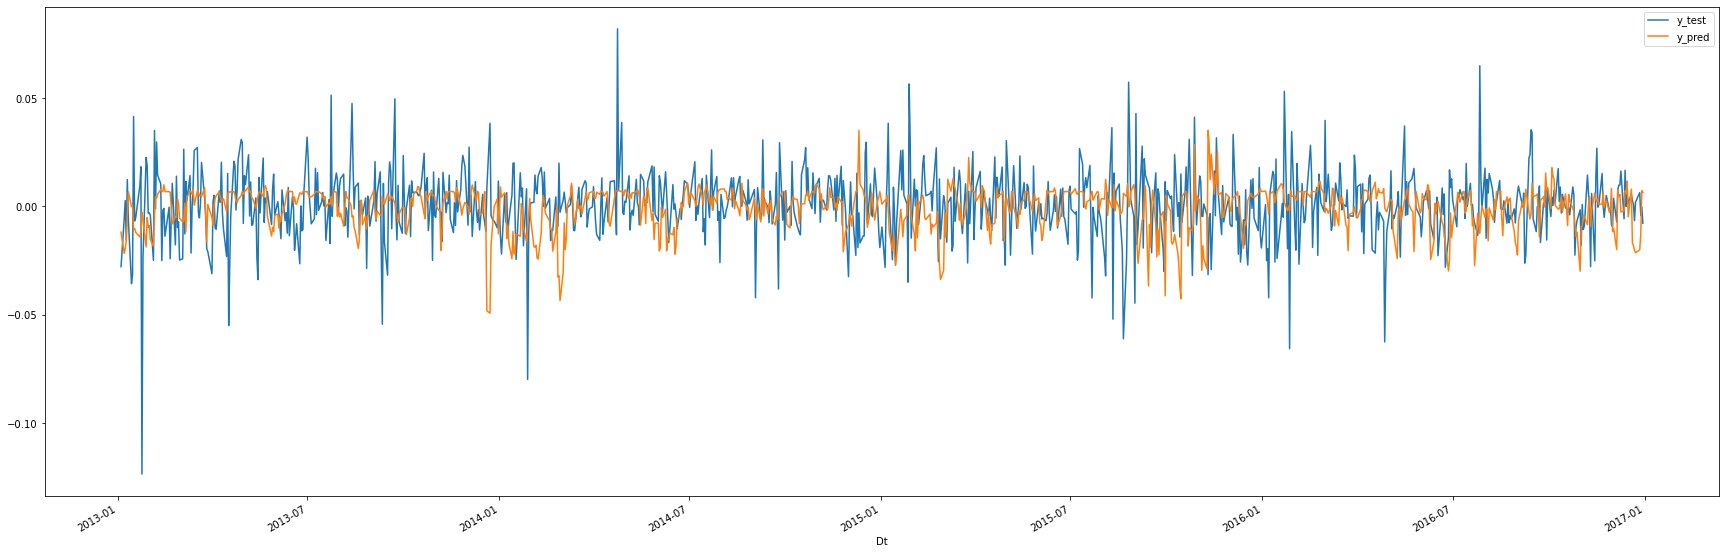

In [86]:
plt.figure()
y_cnn.plot(figsize=(30,10))

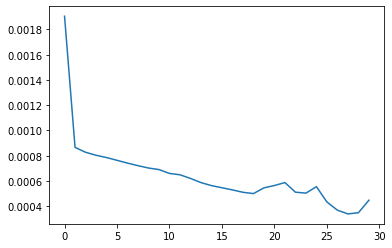

In [87]:
plt.plot(history_CNN1.history['loss'])

In [88]:
model_CNN1.evaluate(Xs_test,ys_test)

32/32 [==============================] - 0s 3ms/step - loss: 3.4436e-04


0.0003443566965870559

Conclusion: I initially read most applications of CNN's were for image classifications, but my intuition to use CNN was that we need to analyse trends and regime changes and stock price patterns. The result was interesting, while it is not inline with the actual returns, it is able to capture the momentum and the spikes.

# RNN with GRU (Gated Recurrent Unit) layers

## RNN using Prices

In [89]:
#Routine to split data into train, val, and test
def train_val_test(data_frame):
  column_indices = {name: i for i, name in enumerate(data_frame.columns)}
  train_upper = 0.7
  val_upper = 0.9
  n = len(data_frame)
  train_df = data_frame[0:int(n*train_upper)]
  val_df = data_frame[int(n*train_upper):int(n*val_upper)]
  test_df = data_frame[int(n*val_upper):]

  num_features = data_frame.shape[1]
  return train_df, val_df, test_df, num_features

In [90]:
train_df, val_df, test_df, num_features = train_val_test(main_frame_TA)
y_act = test_df.iloc[pred_window:,0]

In [91]:
print("train_df shape: ",train_df.shape)
print("val_df shape: ",val_df.shape)
print("test_df shape: ",test_df.shape)
print("number of features: ",num_features)

train_df shape:  (2984, 16)
val_df shape:  (852, 16)
test_df shape:  (427, 16)
number of features:  16


In [92]:
train_max = train_df.max()
train_min = train_df.min()

train_df = (train_df - train_min) / (train_max-train_min)
val_df = (val_df - train_min) / (train_max-train_min)
test_df = (test_df - train_min) / (train_max-train_min)

In [93]:
train_df.tail()

,AAPL_close,MSFT_close,ADBE_close,SPY_close,AAPL_RSI,MSFT_RSI,ADBE_RSI,SPY_RSI,AAPL_ROC,MSFT_ROC,ADBE_ROC,SPY_ROC,AAPL_CCI,MSFT_CCI,ADBE_CCI,SPY_CCI
Dt,,,,,,,,,,,,,,,,
2011-11-23,0.867085,0.348467,0.444083,0.658736,0.262948,0.254234,0.316088,0.310091,0.557019,0.361430,0.308831,0.442817,0.401739,0.376860,0.361678,0.245985
2011-11-25,0.858858,0.342686,0.441311,0.655959,0.242233,0.236052,0.306416,0.304703,0.572411,0.347491,0.306596,0.420892,0.386860,0.399990,0.381840,0.287652
2011-11-28,0.889050,0.362066,0.461219,0.698480,0.366558,0.351496,0.418168,0.435608,0.606566,0.346791,0.321149,0.440164,0.451462,0.456924,0.456770,0.418708
2011-11-29,0.882024,0.361047,0.447359,0.702770,0.346000,0.347600,0.364337,0.447725,0.612695,0.352866,0.308212,0.464466,0.468656,0.471871,0.437672,0.459992
2011-11-30,0.903676,0.386212,0.481380,0.765100,0.424918,0.478780,0.523539,0.599987,0.611622,0.384625,0.347448,0.535775,0.549831,0.532997,0.526157,0.590967


In [94]:
test_df.head()

,AAPL_close,MSFT_close,ADBE_close,SPY_close,AAPL_RSI,MSFT_RSI,ADBE_RSI,SPY_RSI,AAPL_ROC,MSFT_ROC,ADBE_ROC,SPY_ROC,AAPL_CCI,MSFT_CCI,ADBE_CCI,SPY_CCI
Dt,,,,,,,,,,,,,,,,
2015-04-24,2.310094,1.300688,1.719214,2.058031,0.599837,0.945790,0.593685,0.661472,0.653756,0.667980,0.383789,0.569507,0.751795,0.943972,0.645183,0.784842
2015-04-27,2.352406,1.306653,1.719466,2.046098,0.668088,0.951115,0.594448,0.605372,0.674492,0.672039,0.390506,0.570271,0.777446,0.824909,0.655459,0.727793
2015-04-28,2.315094,1.348771,1.706110,2.055183,0.567656,0.986139,0.543792,0.637106,0.662479,0.716842,0.384566,0.572906,0.684213,0.760391,0.605175,0.641212
2015-04-29,2.280816,1.345044,1.721986,2.043386,0.488209,0.972219,0.596091,0.581211,0.643392,0.688026,0.391668,0.555030,0.581938,0.708781,0.612420,0.589963
2015-04-30,2.218510,1.329390,1.707118,2.014775,0.371053,0.912965,0.539153,0.463571,0.620602,0.677320,0.395550,0.534876,0.430713,0.673304,0.589704,0.345173


In [95]:
#This routine creates the time steps for the data
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end = i+ n_steps
		# check if we are beyond the dataset
		if end > len(sequences)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end, :], sequences[end:end+1, 0]
		X.append(seq_x)  
		y.append(seq_y)
	return np.array(X), np.array(y)

In [96]:
X_train, y_train = split_sequences(np.array(train_df),pred_window)
X_val, y_val = split_sequences(np.array(val_df),pred_window)
X_test, y_test = split_sequences(np.array(test_df),pred_window)

In [97]:
#checks if windowing is correct
assert X_train[1][pred_window-1][0] == y_train[0]
assert X_val[1][pred_window-1][0] == y_val[0]
assert X_test[1][pred_window-1][0] == y_test[0]

In [98]:
print("X_train, y_train: ",X_train.shape,"|" ,y_train.shape)
print("X_val, y_val: ",X_val.shape,"|" ,y_val.shape)
print("X_test, y_test: ",X_test.shape,"|" ,y_test.shape)

X_train, y_train:  (2924, 60, 16) | (2924, 1)
X_val, y_val:  (792, 60, 16) | (792, 1)
X_test, y_test:  (367, 60, 16) | (367, 1)


In [99]:
X_train[0].shape

(60, 16)

In [100]:
model_RNN = Sequential()

model_RNN.add(GRU(256, return_sequences=True,input_shape=X_train[0].shape))
model_RNN.add(Dropout(0.2))
model_RNN.add(GRU(256, return_sequences=True))
model_RNN.add(Dropout(0.2))
model_RNN.add(GRU(256, return_sequences=True))
model_RNN.add(Dropout(0.2))
model_RNN.add(Flatten())
model_RNN.add(Dense(1))

model_RNN.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 60, 256)           210432    
                                                                 
 dropout_6 (Dropout)         (None, 60, 256)           0         
                                                                 
 gru_1 (GRU)                 (None, 60, 256)           394752    
                                                                 
 dropout_7 (Dropout)         (None, 60, 256)           0         
                                                                 
 gru_2 (GRU)                 (None, 60, 256)           394752    
                                                                 
 dropout_8 (Dropout)         (None, 60, 256)           0         
                                                                 
 flatten_2 (Flatten)         (None, 15360)            

In [101]:
model_RNN.compile(optimizer='adam', 
              loss='mean_squared_error')

In [102]:
max_epochs = 20
history_RNN = model_RNN.fit(X_train, y_train, 
                          epochs=max_epochs,  
                          validation_data=(X_val, y_val), 
                          shuffle=False
                         )

Epoch 1/20
92/92 [==============================] - 8s 60ms/step - loss: 0.0336 - val_loss: 0.8330
Epoch 2/20
92/92 [==============================] - 4s 46ms/step - loss: 0.1303 - val_loss: 0.2094
Epoch 3/20
92/92 [==============================] - 4s 47ms/step - loss: 0.1259 - val_loss: 0.1203
Epoch 4/20
92/92 [==============================] - 4s 47ms/step - loss: 0.0716 - val_loss: 0.4221
Epoch 5/20
92/92 [==============================] - 4s 46ms/step - loss: 0.0422 - val_loss: 0.1468
Epoch 6/20
92/92 [==============================] - 4s 46ms/step - loss: 0.0467 - val_loss: 0.2886
Epoch 7/20
92/92 [==============================] - 4s 46ms/step - loss: 0.0350 - val_loss: 0.0958
Epoch 8/20
92/92 [==============================] - 4s 46ms/step - loss: 0.0438 - val_loss: 0.2690
Epoch 9/20
92/92 [==============================] - 4s 46ms/step - loss: 0.0295 - val_loss: 0.2230
Epoch 10/20
92/92 [==============================] - 4s 46ms/step - loss: 0.0299 - val_loss: 0.1845
Epoch 11/

In [103]:
y_pred = model_RNN.predict(X_test)


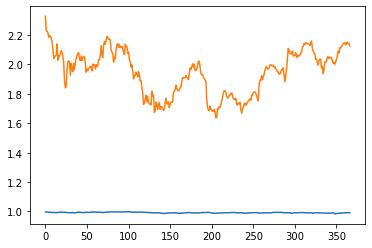

In [104]:
plt.plot(y_pred)
plt.plot(y_test)

In [105]:
y_pred = y_pred*(train_max[0]-train_min[0])+train_min[0]

In [106]:
y_RNN = pd.DataFrame()
y_RNN['y_actual'] = y_act
y_RNN['y_predicted']=y_pred

<AxesSubplot:xlabel='Dt'>

<Figure size 432x288 with 0 Axes>

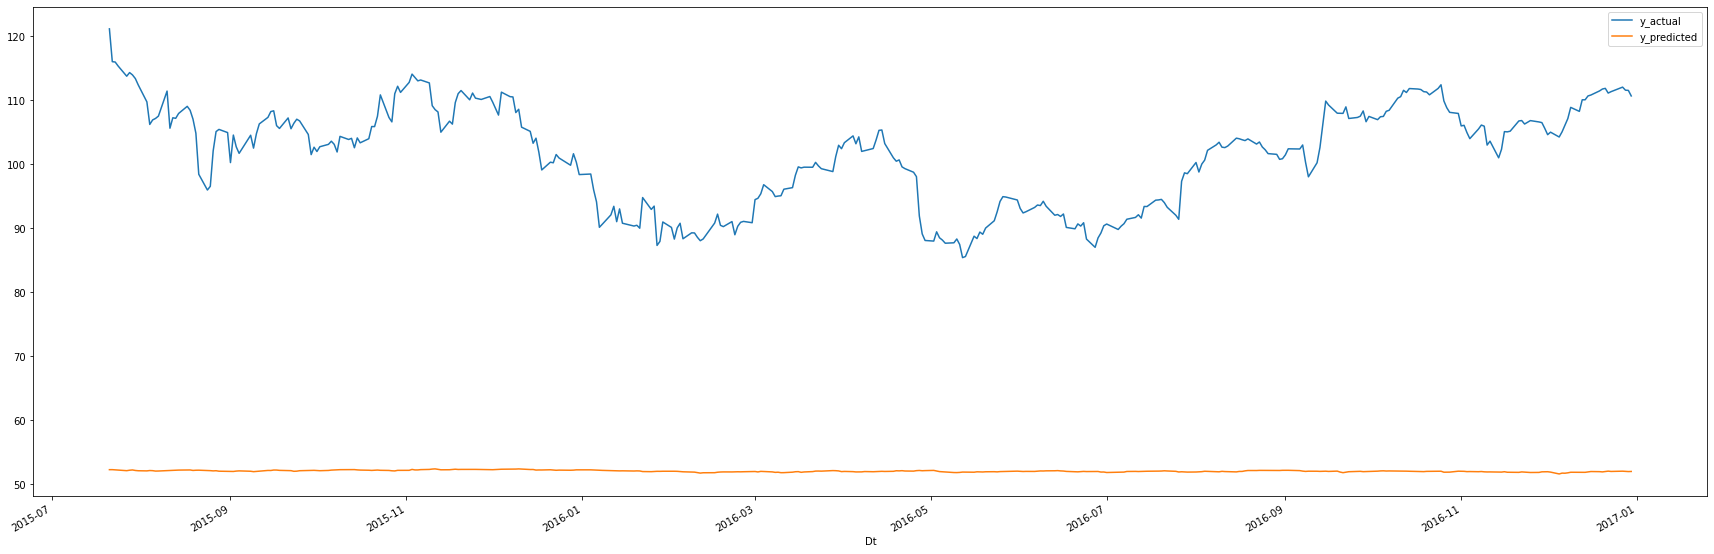

In [107]:
plt.figure()
y_RNN.plot(figsize=(30,10))

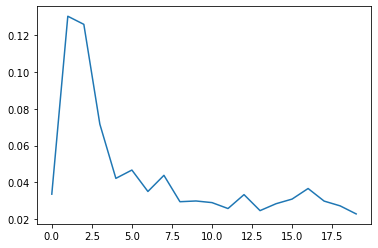

In [108]:
plt.plot(history_RNN.history['loss'])

In [109]:
model_RNN.evaluate(X_test,y_test)

12/12 [==============================] - 0s 31ms/step - loss: 0.9341


0.9341191053390503

## RNN using returns

In [110]:
train_df, val_df, test_df, num_features = train_val_test(main_frame_pct)
y_act = test_df.iloc[pred_window:,0]

In [111]:
train_max = train_df.max()
train_min = train_df.min()

train_df = (train_df - train_min) / (train_max-train_min)
val_df = (val_df - train_min) / (train_max-train_min)
test_df = (test_df - train_min) / (train_max-train_min)

In [112]:
X_train, y_train = split_sequences(np.array(train_df),pred_window)
X_val, y_val = split_sequences(np.array(val_df),pred_window)
X_test, y_test = split_sequences(np.array(test_df),pred_window)

In [113]:
#checks if windowing is correct
assert X_train[1][pred_window-1][0] == y_train[0]
assert X_val[1][pred_window-1][0] == y_val[0]
assert X_test[1][pred_window-1][0] == y_test[0]

In [114]:
model_RNN = Sequential()

model_RNN.add(GRU(256, return_sequences=True,input_shape=X_train[0].shape))
model_RNN.add(Dropout(0.2))
model_RNN.add(GRU(256, return_sequences=True))
model_RNN.add(Dropout(0.2))
model_RNN.add(GRU(256, return_sequences=True))
model_RNN.add(Dropout(0.2))
model_RNN.add(Flatten())
model_RNN.add(Dense(1))

model_RNN.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_3 (GRU)                 (None, 60, 256)           204288    
                                                                 
 dropout_9 (Dropout)         (None, 60, 256)           0         
                                                                 
 gru_4 (GRU)                 (None, 60, 256)           394752    
                                                                 
 dropout_10 (Dropout)        (None, 60, 256)           0         
                                                                 
 gru_5 (GRU)                 (None, 60, 256)           394752    
                                                                 
 dropout_11 (Dropout)        (None, 60, 256)           0         
                                                                 
 flatten_3 (Flatten)         (None, 15360)            

In [115]:
model_RNN.compile(optimizer='adam', 
              loss='mean_squared_error')

In [116]:
max_epochs = 20
history_RNN = model_RNN.fit(X_train, y_train, 
                          epochs=max_epochs,  
                          validation_data=(X_val, y_val), 
                          shuffle=False
                         )

Epoch 1/20
92/92 [==============================] - 8s 60ms/step - loss: 0.0168 - val_loss: 0.0021
Epoch 2/20
92/92 [==============================] - 4s 46ms/step - loss: 0.0032 - val_loss: 0.0022
Epoch 3/20
92/92 [==============================] - 4s 47ms/step - loss: 0.0031 - val_loss: 9.8233e-04
Epoch 4/20
92/92 [==============================] - 4s 48ms/step - loss: 0.0029 - val_loss: 7.5736e-04
Epoch 5/20
92/92 [==============================] - 4s 46ms/step - loss: 0.0031 - val_loss: 8.5961e-04
Epoch 6/20
92/92 [==============================] - 4s 48ms/step - loss: 0.0033 - val_loss: 0.1108
Epoch 7/20
92/92 [==============================] - 4s 47ms/step - loss: 0.1858 - val_loss: 8.2365e-04
Epoch 8/20
92/92 [==============================] - 4s 47ms/step - loss: 0.0039 - val_loss: 7.3701e-04
Epoch 9/20
92/92 [==============================] - 4s 48ms/step - loss: 0.0032 - val_loss: 7.8019e-04
Epoch 10/20
92/92 [==============================] - 4s 48ms/step - loss: 0.0036 - va

In [117]:
y_pred = model_RNN.predict(X_test)

In [118]:
y_pred = y_pred*(train_max[0]-train_min[0])+train_min[0]

In [119]:
y_RNN = pd.DataFrame()
y_RNN['y_actual'] = y_act
y_RNN['y_predicted']=y_pred

<AxesSubplot:xlabel='Dt'>

<Figure size 432x288 with 0 Axes>

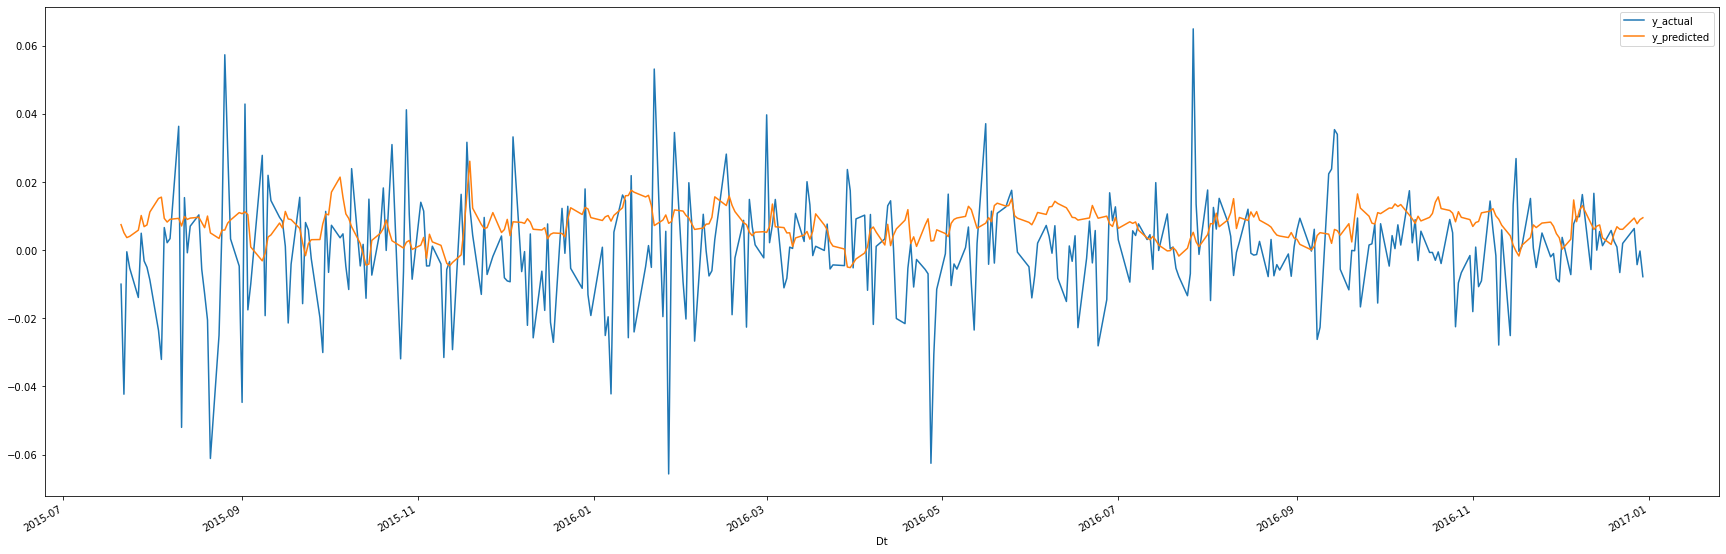

In [120]:
plt.figure()
y_RNN.plot(figsize=(30,10))

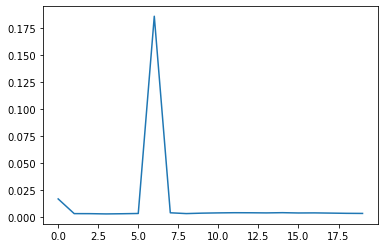

In [121]:
plt.plot(history_RNN.history['loss'])

In [122]:
model_RNN.evaluate(X_test,y_test)

12/12 [==============================] - 0s 33ms/step - loss: 7.7799e-04


0.0007779933512210846

Conclusion: 


*  In case of the RNN model, it is better to use percentage returns vs actual prices
*  The issue with RNN with GRU is that it doesn't capture the trend as well as CNN did
*  While it is better than the plain LSTM, it is still not able to move as fast as the actual return changes




# LSTM Return Model with multiple features

Trying to evaluate if adding more features can help improve the LSTM model for returns prediction

In [123]:
main_frame_pct

,AAPL_close,MSFT_close,ADBE_close,SPY_close,AAPL_RSI,MSFT_RSI,ADBE_RSI,SPY_RSI
Dt,,,,,,,,
2000-01-25,0.056486,0.015431,0.040250,0.011356,0.125921,0.134737,0.210637,0.125148
2000-01-26,-0.018376,-0.033434,-0.028769,-0.007926,-0.045456,-0.121216,-0.096489,-0.056933
2000-01-27,-0.001694,-0.006288,0.024512,-0.003995,-0.004410,-0.023181,0.107531,-0.029744
2000-01-28,-0.076149,-0.005064,-0.081756,-0.031194,-0.175690,-0.019585,-0.225635,-0.199442
2000-01-31,0.020899,-0.003819,-0.043433,0.027138,0.056921,-0.015579,-0.105974,0.325775
...,...,...,...,...,...,...,...,...
2016-12-23,0.001978,-0.004878,0.002865,0.001464,0.012727,-0.047970,0.023312,0.014790
2016-12-27,0.006351,0.000632,-0.000381,0.002481,0.039408,0.003811,-0.003366,0.024621
2016-12-28,-0.004264,-0.004583,-0.011526,-0.008265,-0.050938,-0.049161,-0.098823,-0.149227


In [124]:
train_df, val_df, test_df, num_features = train_val_test(main_frame_pct)
y_act = test_df.iloc[pred_window:,0]

In [125]:
print("train_df shape: ",train_df.shape)
print("val_df shape: ",val_df.shape)
print("test_df shape: ",test_df.shape)
print("number of features: ",num_features)

train_df shape:  (2983, 8)
val_df shape:  (852, 8)
test_df shape:  (427, 8)
number of features:  8


In [126]:
#Windowing data
X_train, y_train = split_sequences(np.array(train_df),pred_window)
X_val, y_val = split_sequences(np.array(val_df),pred_window)
X_test, y_test = split_sequences(np.array(test_df),pred_window)

#checks if windowing is correct
assert X_train[1][pred_window-1][0] == y_train[0]
assert X_val[1][pred_window-1][0] == y_val[0]
assert X_test[1][pred_window-1][0] == y_test[0]

print("X_train, y_train: ",X_train.shape,"|" ,y_train.shape)
print("X_val, y_val: ",X_val.shape,"|" ,y_val.shape)
print("X_test, y_test: ",X_test.shape,"|" ,y_test.shape)

X_train, y_train:  (2923, 60, 8) | (2923, 1)
X_val, y_val:  (792, 60, 8) | (792, 1)
X_test, y_test:  (367, 60, 8) | (367, 1)


In [127]:
input_shape = X_train[0].shape
model_LSTM = Sequential()
model_LSTM.add(LSTM(units = 60, return_sequences = True,input_shape = input_shape))
model_LSTM.add(Dropout(0.2))
model_LSTM.add(LSTM(units = 60))
model_LSTM.add(Dropout(0.2))
model_LSTM.add(Dense(units=1))
model_LSTM.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 60, 60)            16560     
                                                                 
 dropout_12 (Dropout)        (None, 60, 60)            0         
                                                                 
 lstm_7 (LSTM)               (None, 60)                29040     
                                                                 
 dropout_13 (Dropout)        (None, 60)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                 61        
                                                                 
Total params: 45,661
Trainable params: 45,661
Non-trainable params: 0
_________________________________________________________________


In [128]:
model_LSTM.compile(optimizer='sgd', loss='mse')

max_epochs = 10
history_LSTM = model_LSTM.fit(X_train, y_train, 
                          epochs=max_epochs,  
                          validation_data=(X_val, y_val), 
                          shuffle=False
                         )

Epoch 1/10
92/92 [==============================] - 7s 48ms/step - loss: 8.8316e-04 - val_loss: 2.8498e-04
Epoch 2/10
92/92 [==============================] - 3s 32ms/step - loss: 8.8272e-04 - val_loss: 2.8502e-04
Epoch 3/10
92/92 [==============================] - 3s 33ms/step - loss: 8.8206e-04 - val_loss: 2.8504e-04
Epoch 4/10
92/92 [==============================] - 3s 33ms/step - loss: 8.8148e-04 - val_loss: 2.8506e-04
Epoch 5/10
92/92 [==============================] - 3s 32ms/step - loss: 8.8097e-04 - val_loss: 2.8508e-04
Epoch 6/10
92/92 [==============================] - 3s 32ms/step - loss: 8.8052e-04 - val_loss: 2.8510e-04
Epoch 7/10
92/92 [==============================] - 3s 32ms/step - loss: 8.8011e-04 - val_loss: 2.8512e-04
Epoch 8/10
92/92 [==============================] - 3s 32ms/step - loss: 8.7974e-04 - val_loss: 2.8513e-04
Epoch 9/10
92/92 [==============================] - 3s 32ms/step - loss: 8.7941e-04 - val_loss: 2.8514e-04
Epoch 10/10
92/92 [==================

In [129]:
y_pred = model_LSTM.predict(X_test)

In [130]:
y_LSTM = pd.DataFrame()
y_LSTM['y_actual'] = y_act
y_LSTM['y_predicted']=y_pred

<AxesSubplot:xlabel='Dt'>

<Figure size 432x288 with 0 Axes>

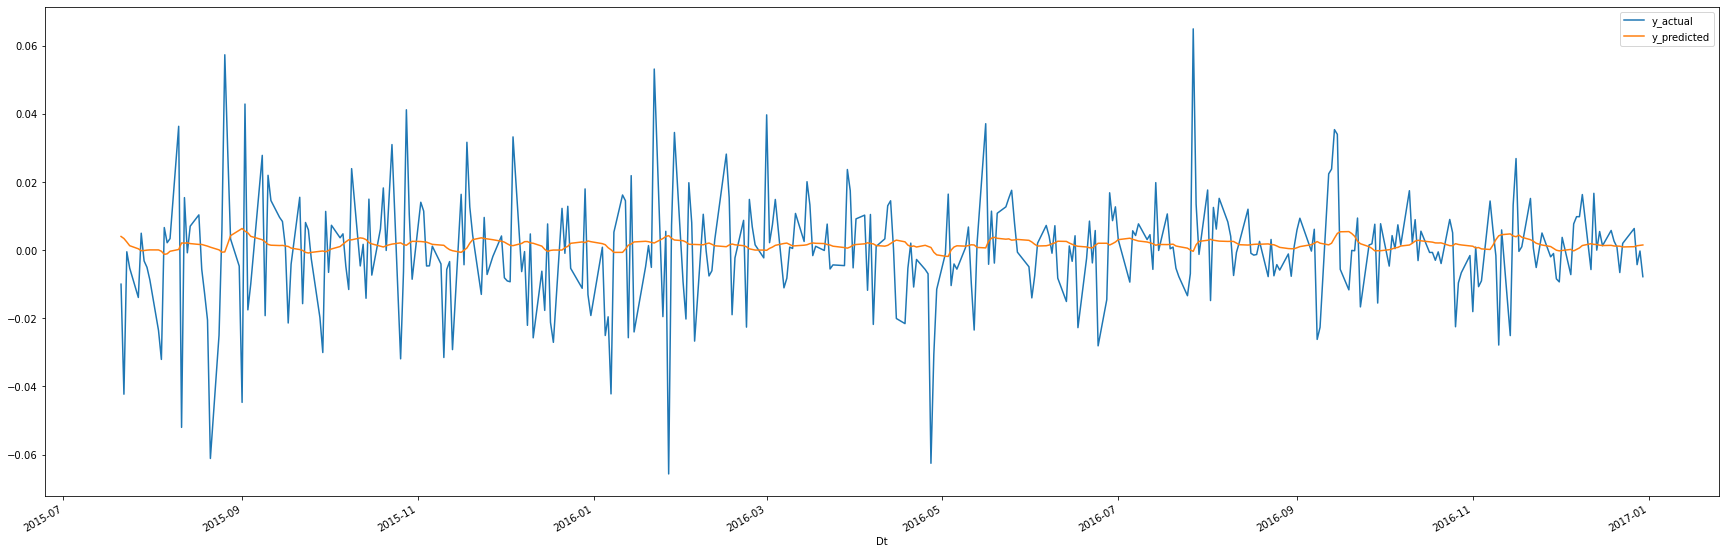

In [131]:
plt.figure()
y_LSTM.plot(figsize=(30,10))

As we can see this is an improvement from the 1.2 LSTM for Returns model, where the returns we straight line, but the model still fails to show as much as variance of the actual data

# MyModel - 1D CNN model

I chose 1D CNN model because it was the one that most explained the variance of returns vs other models. I also found it intuitive that since it is most used for image classification tasks, it can be analogous to identifying patterns in the stock returns

In [132]:
#path is the location of the data eg: ./Data/holdout
def MyModel(path):
    
    def split_sequences(sequences, n_steps):
        X, y = list(), list()
        for i in range(len(sequences)):
            # find the end of this pattern
            end = i+ n_steps
            # check if we are beyond the dataset
            if end > len(sequences)-1:
                break
            # gather input and output parts of the pattern
            seq_x, seq_y = sequences[i:end, :], sequences[end:end+1, 0]
            X.append(seq_x)  
            y.append(seq_y)
        return np.array(X), np.array(y)

    #Loading Training Set
    # Adding tech stocks and SPY index
    tech_list = ["AAPL", "MSFT","ADBE","SPY"]
    df_list = []
    for i, stock in zip(range(len(tech_list)),tech_list):
        globals()[stock] = pd.read_csv('./Data/train/'+tech_list[i]+'.csv',index_col=0)
        globals()[stock].index = pd.to_datetime(globals()[stock].index)
        df_list.append(globals()[stock])

    #Only retaining the Close, High, Low
    tech_list = ["AAPL","MSFT","ADBE","SPY"]
    tech_list_close = ['AAPL_close','MSFT_close','ADBE_close','SPY_close']
    tech_list_high = ['AAPL_high','MSFT_high','ADBE_high','SPY_high']
    tech_list_low = ['AAPL_low','MSFT_low','ADBE_low','SPY_low']
    main_frame = pd.DataFrame()

    for stock, stock_close,stock_high,stock_low in zip(tech_list,tech_list_close,tech_list_high,tech_list_low):
        main_frame[stock_close]= globals()[stock]['Close']
        main_frame[stock_high]= globals()[stock]['High']
        main_frame[stock_low]= globals()[stock]['Low']

    #Adding RSI
    main_frame_TA = main_frame.copy()
    tech_ind = '_RSI'
    RSI_ls = [s + tech_ind for s in tech_list]
    for ls, stock_close in zip(RSI_ls,tech_list_close):
        main_frame_TA[ls] = ta.rsi(main_frame[stock_close])

    #Converting to % returns
    main_frame_pct = main_frame_TA.pct_change()
    main_frame_pct = main_frame_pct.dropna()

    #Spliting Data; shuffle = False
    X=main_frame_pct
    y=main_frame_pct.iloc[:,0]
    X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(X,y,test_size =0.25,random_state = 42,shuffle=False)

    #Windowing the data
    pred_window = 60
    X_train, y_train =split_sequences(np.array(X_train),pred_window)
    X_val, y_val =split_sequences(np.array(X_val),pred_window)

    #Running a 1D CNN model
    model_CNN = None

    input_shape = X_train[2].shape

    model_CNN = Sequential()
    model_CNN.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=input_shape))
    model_CNN.add(MaxPooling1D(pool_size=4))
    model_CNN.add(Flatten())
    model_CNN.add(Dense(80, activation='relu'))
    model_CNN.add(Dense(1))

    model_CNN.summary()

    model_CNN.compile(optimizer='adam', loss='mse')
    max_epochs = 10
    history_CNN = model_CNN.fit(X_train, y_train, 
                            epochs=max_epochs,
                            validation_data=(X_val, y_val), 
                            shuffle=False
                          )

    #Reading the Test Data
    for i, stock in zip(range(len(tech_list)),tech_list):
        globals()[stock] = pd.read_csv(path+tech_list[i]+'.csv',index_col=0)
        globals()[stock].index = pd.to_datetime(globals()[stock].index)

    Test = pd.DataFrame()
    for stock, stock_close,stock_high,stock_low in zip(tech_list,tech_list_close,tech_list_high,tech_list_low):
        Test[stock_close]= globals()[stock]['Close']
        Test[stock_high]= globals()[stock]['High']
        Test[stock_low]= globals()[stock]['Low']

    #Adding RSI
    Test_TA = Test.copy()
    tech_ind = '_RSI'
    RSI_ls = [s + tech_ind for s in tech_list]
    for ls, stock_close in zip(RSI_ls,tech_list_close):
        Test_TA[ls] = ta.rsi(Test[stock_close])

    #Converting to % returns
    Test_TA_pct = Test_TA.pct_change()
    Test_TA_pct = Test_TA_pct.dropna()

    X_test, y_test =split_sequences(np.array(Test_TA_pct),pred_window)

    y_pred = model_CNN.predict(X_test)

    return y_pred



In [133]:
y_pred = MyModel('./Data/sample/')

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 59, 64)            2112      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 14, 64)           0         
 1D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 896)               0         
                                                                 
 dense_9 (Dense)             (None, 80)                71760     
                                                                 
 dense_10 (Dense)            (None, 1)                 81        
                                                                 
Total params: 73,953
Trainable params: 73,953
Non-trainable params: 0
__________________________________________________

In [ ]:
#Predictions for the holdout set
y_pred = MyModel('./Data/holdout/')

In [136]:
print("done")

done
